In [1]:
# требуемые библиотеки
# pip install psycopg2-binary
# pip install matplotlib

In [17]:
import matplotlib.pyplot as plt
import psycopg2
import time

In [18]:
# Параметры подключения к базам данных
PRIMARY_DB = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5433'
}

STANDBY_DB = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5434'
}

In [22]:
# Логгер количества записей
insert_time = [0]
primary_count = [0]
standby_count = [0]

def log_clear():
    global insert_time
    global primary_count
    global standby_count
    insert_time = [0]
    primary_count = [0]
    standby_count = [0]


def log_db(db_config):
    try:
        with psycopg2.connect(**db_config) as conn:
            with conn.cursor() as cur:
                cur.execute("SELECT COUNT(*) FROM data_table")
                count = cur.fetchone()[0]
        return count
    except Exception as e:
        return -1


def log():
    insert_time.append(insert_time[-1] + 1)
    primary_count.append(log_db(PRIMARY_DB))
    standby_count.append(log_db(STANDBY_DB))


def plot_logs():
    plt.plot(insert_time, primary_count, label='primary', marker='o')
    plt.plot(insert_time, standby_count, label='standby')
    plt.legend()
    plt.xlabel("Порядковый номер запроса")
    plt.ylabel("Количество записей") 
    plt.show()

In [23]:
# reverse proxy для переключения с PRIMARY_DB на STANDBY_DB
is_primary_alive = True


def promote(db_config):
    with psycopg2.connect(**db_config) as conn:
        with conn.cursor() as cur:
            cur.execute("SELECT pg_promote()")
            conn.commit()


def proxy_insert(value):
    global is_primary_alive
    if is_primary_alive:
        if not raw_insert(PRIMARY_DB, value):
            is_primary_alive = False
            promote(STANDBY_DB)
    elif not is_primary_alive:
        raw_insert(STANDBY_DB, value)

    
def raw_insert(db_config, value):
    try:
        with psycopg2.connect(**db_config) as conn:
            with conn.cursor() as cur:
                cur.execute("INSERT INTO data_table (name) VALUES (%s)", (value,))
                conn.commit()
        return True
    except Exception as e:
        print(f"Ошибка при вставке данных: {e}")  # Логируем ошибку
        return False

In [24]:
# Получение данных которые наобходимо записать в БД
def get_value() -> str:
    return "test string"

Ошибка при вставке данных: connection to server at "localhost" (127.0.0.1), port 5433 failed: FATAL:  the database system is shutting down

количество записей в primary 48/100
количество записей в standby 99/100


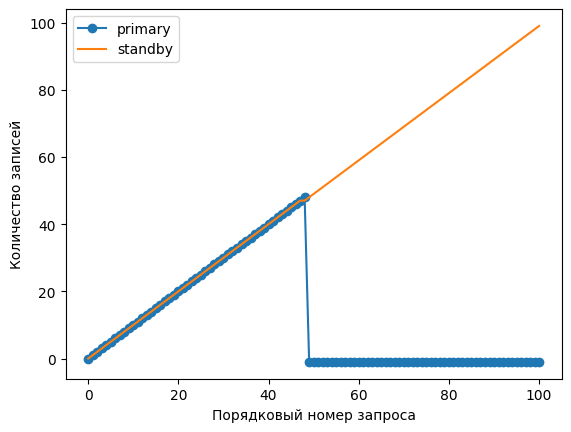

In [28]:
is_primary_alive = True
log_clear()

interval = 0.1  # Период поступления данных
duration = 10   # Длительность 
iterations = int(duration / interval)
    
for _ in range(iterations):
    proxy_insert(get_value())
    log()
    time.sleep(interval)
    
print(f'количество записей в primary {max(primary_count)}/{iterations}')
print(f'количество записей в standby {max(standby_count)}/{iterations}')
plot_logs()